# Week6 Time Series 정규세션 과제

### 주가 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
### Box-Jenkins 방법론
- 식별
- 추정
- 진단
- 예측

## 라이브러리 불러오기

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
!pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMAResults

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.1 MB/s eta 0:00:00


<ipython-input-2-1cfa4f50743f>:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## 주가 데이터 불러오기
- 예) 삼성 005930.KS

In [ ]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


reference ) https://velog.io/@isitcake_yes/mlarimastockprediction

### 원본시계열, 이동평균, 이동표준편차 시각화

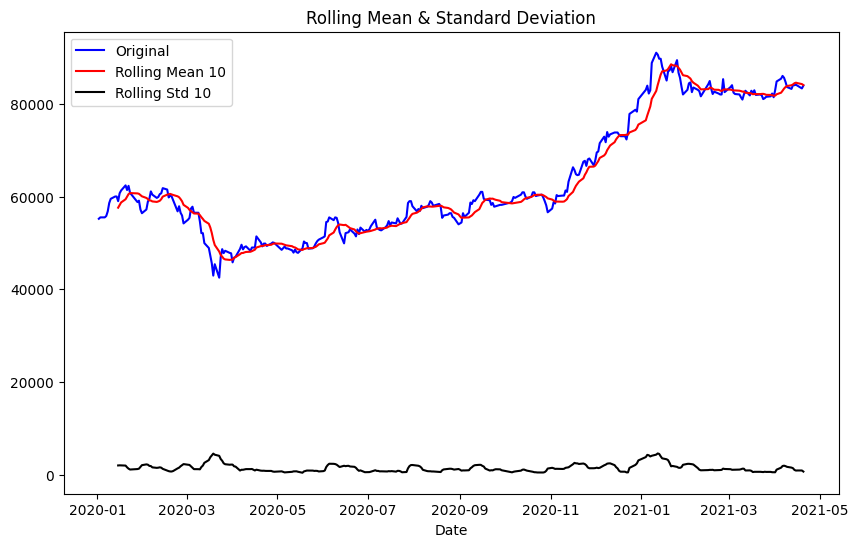

In [ ]:
def plot_rolling(data, interval):
  rolmean = data.rolling(interval).mean()
  rolstd = data.rolling(interval).std()
  plt.figure(figsize = (10, 6))
  plt.xlabel('Date')
  orig = plt.plot(data, color = 'blue', label = 'Original')
  mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean {}'.format(interval))
  std = plt.plot(rolstd, color = 'black', label = 'Rolling Std {}'.format(interval))
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show()

plot_rolling(samsung_df, 10)

## 1.  정상성 확인 - ADF 테스트

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(data):
    result = adfuller(data.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('num of lags: %f' % result[2])
    print('num of observations: %f' % result[3])
    print('Critical values:')
    for k, v in result[4].items():
        print('\t%s: %.3f' % (k,v))

print('ADF TEST 결과')
adf_test(samsung_df)


ADF TEST 결과
ADF Statistics: -0.212189
p-value: 0.937053
num of lags: 0.000000
num of observations: 321.000000
Critical values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


해석 : p-value > 0.05이므로 귀무가설을 기각할 수 없다. 따라서 삼성 주식 데이터는 비정상성 데이터이다.

정상성 : 관측된 시간에 대해 무관한 데이터. 평균과 분산이 일정
비정상성 : 시간에 따라 평균 수준이 다르거나 추세나 계절성에 영향을 받는 데이터.
- 비정상성 데이터를 정상성으로 변환하여 분석을 진행하면 예측 범위가 일정 범위로 줄어들어 예측 성능이 개선되고, 고려할 파라미터 수가 감소하여 단순한 알고리즘으로 예측이 가능하며 overfitting 방지도 가능.
- 변환 방법중에는 평균의 정상화를 위한 차분과 분산의 안정화를 위한 로그 변환, 제곱/제곱근 변환 등이 있다.

ADF TEST 결과
ADF Statistics: -17.602795
p-value: 0.000000
num of lags: 0.000000
num of observations: 320.000000
Critical values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


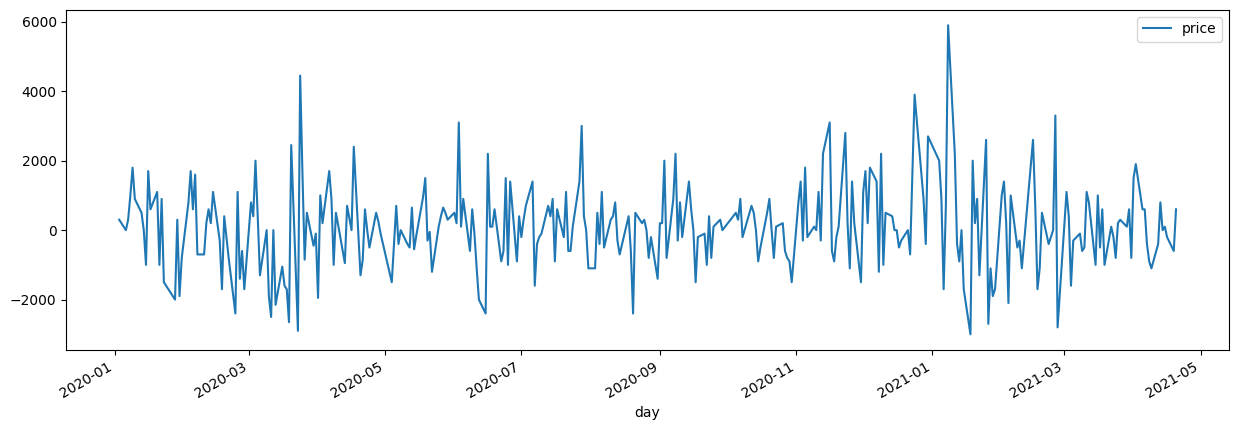

In [ ]:
# 1차 차분 데이터 diff1

diff1 = samsung_df.diff().dropna()
diff1.plot(figsize=(15,5))

print('ADF TEST 결과')
adf_test(diff1)

해석 : p-value가 0.05미만이므로 대립가설 기각, 귀무가설 채택. 1차 차분 처리한 데이터가 정상성 데이터가 되었다. => 비정상성 데이터는 차분을 이용하여 안정적으로 만들어 분석한다.

## 2. ARIMA(p, d, q) 모수 추정

AR(p), 차분(d), MA(q)에서 보통 p+q <2, p*q=0 인 값을 많이 사용한다. (p,q둘 중 한 값이 0)
실제로는 AR 이나 MA 둘중 하나의 경향을 강하게 띄기 때문에 주로 이렇게 사용한다.
추정 방법은 (방법1)ACF plot과 PACF plot을 통해 모수 추정 하는 것과 (방법2)pmdarima 라이브러리의 ndiffs, auto_arima 함수를 사용하여 모수 추정하는 방법이 있다.

- ACF Plot(자기상관함수, Autucorrelation Function plot) : 현재값 S(t)에 S(t-p)값 부터 S(t)에 도달하기까지의 값들의 영향까지 고려
( S(t-p), S(t-p+1), S(t-p+2) .. S(t)값 )

- PACF plot (편자기상관함수, Partial Autocorrelation Function plot) : 현재값 S(t)에 S(t-p)값이 주는 영향만 의미

- 정상 시계열 데이터의 경우, ACF는 상대적으로 빠르게 0(상관관계 0)에 접근하고,
- 비정상 시계열 데이터의 경우, ACF는 천천히 감소하며 종종 큰 양의 값을 가진다.



해석) ACF plot가 천천히 감소되는 것으로 보아 주식 데이터는 주기에 따라 일정하지 않은 비정상성 데이터이고,
PACF plot에서 첫값으로부터 1개 이후 파란 박스에 들어가면서 그래프가 끊기는 것으로 보아 AR(1) 모델을 활용하는 것이 가장 적절할 것으로 예상된다.

방법2를 pmdarima 라이브러리로 차분, 모형차수 결정

차분 결정

In [ ]:
import pmdarima as pm
from pmdarima.arima import ndiffs
n_diffs = ndiffs(samsung_df, alpha=0.05, test='adf', max_d=6)
print(f"추정된 차수 d = {n_diffs}") # 결과

추정된 차수 d = 1


모형 차수 결정

In [ ]:
model = pm.auto_arima(
            y=samsung_df,
            d=1,
            start_p=0, max_p=5,
            start_q=0, max_q=5,
            m=1, seasonal=False, # 계절성이 없음!
            stepwise=True,
            trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5477.791, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5479.719, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5479.737, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5477.510, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5481.732, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.715 seconds


해석) auto_arima를 사용한 결과 최적의 모델은 ARIMA (0,1,0) 모형으로 나왔다.

## 3. 잔차 검정

: 잔차가 정상성(백색잡음인지), 정규성, 등분산성 등을 만족하는지 파악. model.summary(), model.plot_diagnostics()

In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  322
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2737.755
Date:                Thu, 22 Feb 2024   AIC                           5477.510
Time:                        05:12:18   BIC                           5481.281
Sample:                             0   HQIC                          5479.016
                                - 322                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.494e+06   8.32e+04     17.947      0.000    1.33e+06    1.66e+06
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                61.49
Prob(Q):                              0.82   Pr

해석) Ljung-Box (Q), Heteroskedasticity (H), Jarque-Bera (JB)에 대한 부분은 모두 잔차에 대한 검정 통계량이다.

- Ljung-Box(Q) : "H0 : 잔차가 백색잡음이다" => p-value > 0.05이므로 귀무가설 채택 => 잔차가 백색잡음이다. 시계열 모형이 잘 적합되었다.
- Heteroskedasticity(H) : "H0: 잔차가 이분산을 띄지 않는다" => p-value > 0.05이므로 귀무가설 채택 => 잔차는 이분산성을 띄지 않는다.
- Jarque-Bera(JB) : "잔차가 정규성을 만족한다" => p-value > 0.05이므로 귀무가설 채택 => 잔차가 정규성을 따른다.

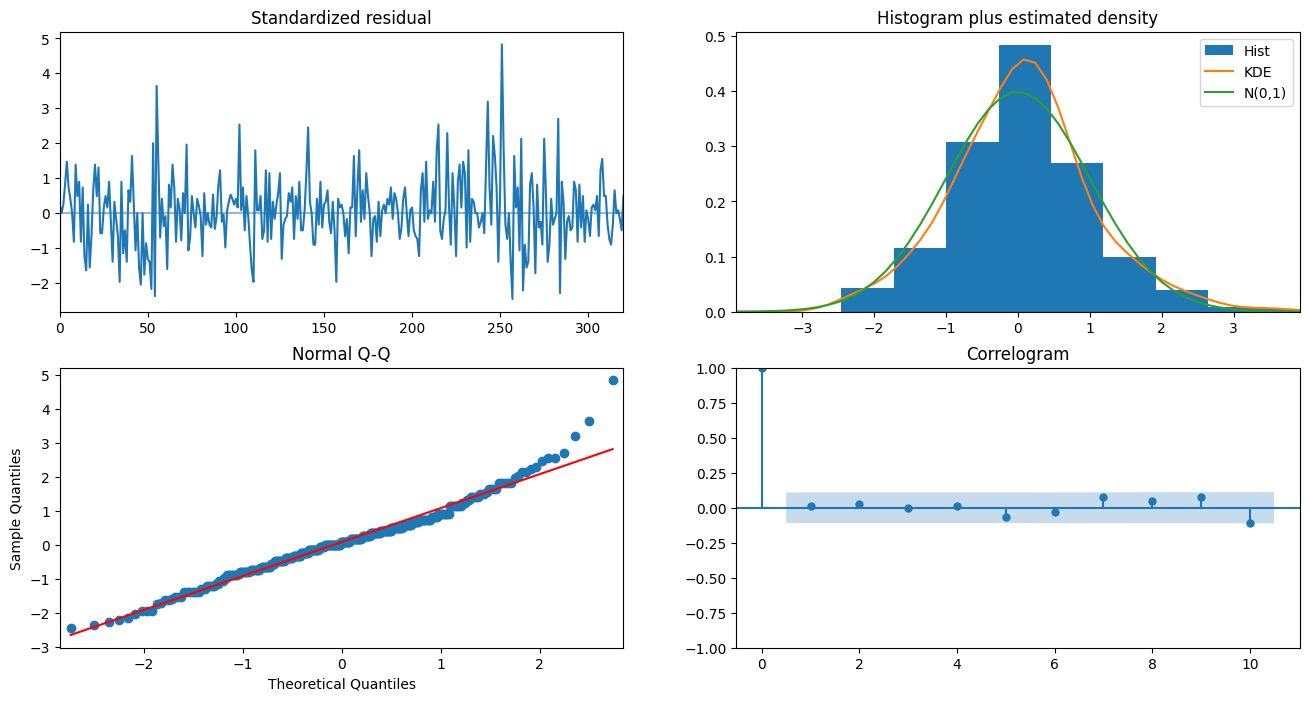

In [ ]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

해석) 잔차는 백색잡음(정상성)이고, 정규성을 따른다.

## 4. ARIMA 모델 훈련과 테스트

1. train, test split

In [ ]:
train_df, test_df = samsung_df[:int(len(samsung_df)*0.9)], samsung_df[int(len(samsung_df)*0.9):]
print(train_df.shape, test_df.shape)

(289, 1) (33, 1)


2. 모델 학습

In [ ]:

model_fit = pm.auto_arima(
    	    y=train_df,
 	        d=n_diffs ,
            start_p=0, max_p=2,
            start_q=0, max_q=2,
            m=1, seasonal=False, # 계절성이 없음!
            stepwise=True,
            trace=True
)
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4935.053, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4937.005, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4937.025, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4934.658, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4939.023, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.728 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  289
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2466.329
Date:                Thu, 22 Feb 2024   AIC                           4934.658
Time:                        05:21:45   BIC                           4938.321
Sample:                             0   HQIC                          4936.126
                                - 289                                       

3. test_df 와 예측값 비교

In [ ]:
samsung_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 322 entries, 2020-01-02 to 2021-04-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   322 non-null    float64
dtypes: float64(1)
memory usage: 5.0 KB


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


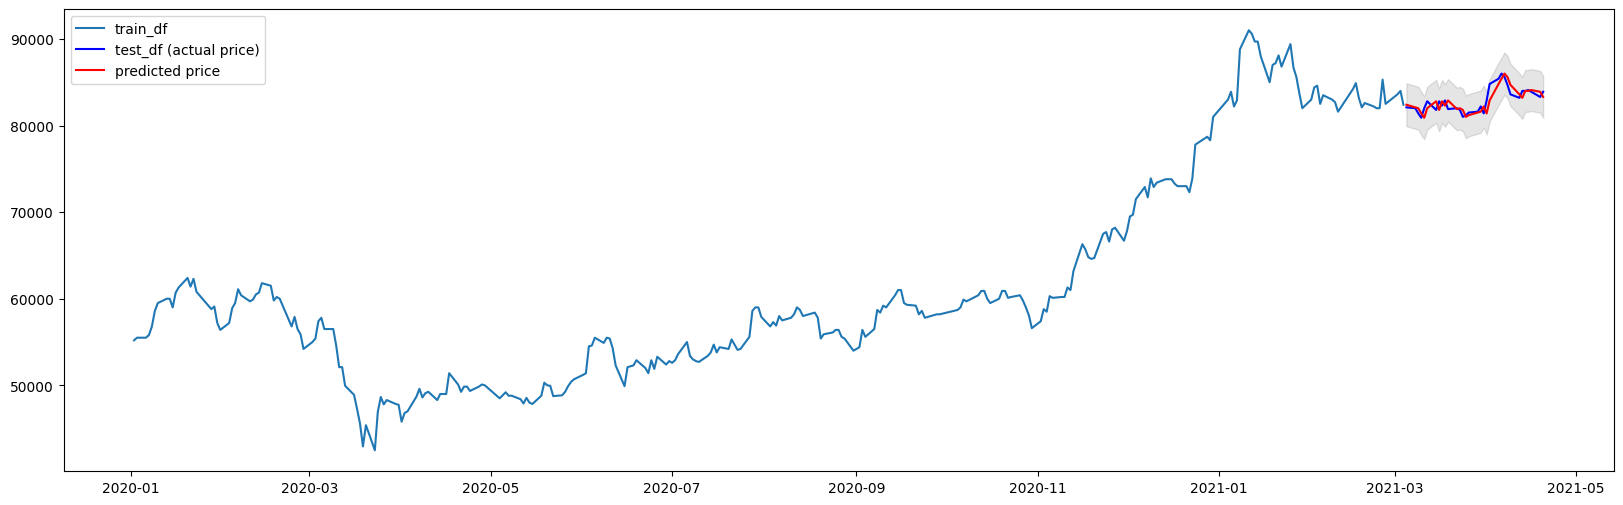

In [ ]:
# forecast 함수
def forecast_n_step(model, n = 1):
    fc, conf_int = model.predict(n_periods=n, return_conf_int=True)
    # print("fc", fc,"conf_int", conf_int)
    return (
        fc.tolist()[0:n], np.asarray(conf_int).tolist()[0:n]
   )

def forecast(len, model, index, data=None):
    y_pred = []
    pred_upper = []
    pred_lower = []

    if data is not None:
        for new_ob in data.values:
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(new_ob)
    else:
        for i in range(len):
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(fc[0])
    return pd.Series(y_pred, index=index), pred_upper, pred_lower

# test_df와 예측값 그래프
# Forecast
fc, upper, lower = forecast(len(test_df), model_fit, test_df.index, data = test_df)

# pandas series 생성
# fc # 예측결과
lower_series = pd.Series(lower, index=test_df.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(upper, index=test_df.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(20,6))
plt.plot(train_df, label='train_df')
plt.plot(test_df, c='b', label='test_df (actual price)')
plt.plot(fc, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend(loc='upper left')
plt.show()

4. 모델의 오차율 계산

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(test_df, fc)
mae = mean_absolute_error(test_df, fc)
rmse = math.sqrt(mse)
mape = np.mean(np.abs((test_df.values - fc.values) / test_df.values)) * 100

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape:.2f}%")

MSE: 555454.5454545454
MAE: 615.1515151515151
RMSE: 745.2882297839845
MAPE: 1.85%
